In [6]:
# HIDDEN
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stat
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# P-hacking
As we discussed, a p-value or probability value is the chance, based on the model in the null hypothesis, that the test statistic is equal to the value that was observed in the data or is even further in the direction of the alternative. If a p-value is small, that means the tail beyond the observed statistic is small and so the observed statistic is far away from what the null predicts. This implies that the data support the alternative hypothesis better than they support the null. By convention, when we see that the p-value is below 0.05, the result is called statistically significant, and we reject the null hypothesis.

There are dangers that present itself when the p-value is misused. *P-hacking* is the act of misusing data analysis to show that patterns in data are statistically significant, when in reality they are not. This is often done by performing multiple tests on data and only focusing on the tests that return results that are significant. 

In this section, we will go over a few examples of the dangers of p-values and p-hacking.

## Multiple Hypothesis Testing


One of the biggest dangers of blindly relying on the p-value to determine "statistical significance" comes when we are just trying to find the "sexiest" results that give us "good" p-values. This is commonly done when doing "food frequency questionairres," or FFQs, to study eating habits' correlation with other characteristics (diseases, weight, religion, etc). 
FiveThirtyEight, an online blog that focuses on opinion poll analysis among other things, made their own FFQ, and we can use their data to run our own analysis to find some silly results that can be considered "statistically significant."

In [45]:
data = pd.read_csv('raw_anonymized_data.csv')
# Do some EDA on the data so that categorical values get changed to 1s and 0s
data.replace('Yes', 1, inplace=True)
data.replace('Innie', 1, inplace=True)
data.replace('No', 0, inplace=True)
data.replace('Outie', 0, inplace=True)

# These are some of the columns that give us characteristics of FFQ-takers
characteristics = ['cat', 'dog', 'right_hand', 'left_hand']

# These are some of the columns that give us the quantities/frequencies of different food the FFQ-takers ate
ffq = ['EGGROLLQUAN', 'SHELLFISHQUAN', 'COFFEEDRINKSFREQ']

We will look specifically whether people own cats, dogs, or what handedness they are.

In [46]:
data[characteristics].head()

,cat,dog,right_hand,left_hand
0,0,0,1,0
1,0,0,1,0
2,0,1,1,0
3,0,0,1,0
4,0,0,1,0


Additionally, we will look at how much shellfish, eggrolls, and coffee people consumed.

In [47]:
data[ffq].head()

,EGGROLLQUAN,SHELLFISHQUAN,COFFEEDRINKSFREQ
0,1,3,2
1,1,2,3
2,2,3,3
3,3,2,1
4,2,2,2


So now we can calculate the p-value for every pair of characteristic and food frequency/quantity features. 

In [52]:
# HIDDEN
def findpvalue(data, c, f):
    return stat.pearsonr(data[c].tolist(), data[f].tolist())[1]

In [55]:
# Calculate the p value between every characteristic and food frequency/quantity pair
pvalues = {}
for c in characteristics:
    for f in ffq:
        pvalues[(c,f)] = findpvalue(data, c, f)

In [56]:
pvalues

{('cat', 'EGGROLLQUAN'): 0.69295273146288583,
 ('cat', 'SHELLFISHQUAN'): 0.39907214094767007,
 ('cat', 'COFFEEDRINKSFREQ'): 0.0016303467897390215,
 ('dog', 'EGGROLLQUAN'): 2.8476184473490123e-05,
 ('dog', 'SHELLFISHQUAN'): 0.14713568495622972,
 ('dog', 'COFFEEDRINKSFREQ'): 0.3507350497291003,
 ('right_hand', 'EGGROLLQUAN'): 0.20123440208411372,
 ('right_hand', 'SHELLFISHQUAN'): 0.00020312599063263847,
 ('right_hand', 'COFFEEDRINKSFREQ'): 0.48693234457564749,
 ('left_hand', 'EGGROLLQUAN'): 0.75803051153936374,
 ('left_hand', 'SHELLFISHQUAN'): 0.00035282554635466211,
 ('left_hand', 'COFFEEDRINKSFREQ'): 0.1692235856830212}

Our study finds that:

|Eating/Drinking|is linked to:|P-value|
|---------------|-------------|-------|
|Egg rolls      |Dog ownership|<0.0001|
|Shellfish      |Right-handedness|0.0002|
|Shellfish      |Left-handedness|0.0004|
|Coffee         |Cat ownership|0.0016|

Clearly this is flawed! Aside from the fact that some of these correlations seem to make no sense, we also found that shellfish is linked to both right and left handedness! Because we blindly tested all columns against each other for statistical significance, we were able to just choose whatever pairs gave us "statistically significant" results. This shows the dangers of blindly following the p-value without a care for proper experimental design.

## A/B Testing
A/B testing is a very simple concept. We measure a statistic in a normal, controlled environment (we'll call this A), and then we compare that to the same statistic in an environment with *one* change. This form of testing is used frequently in marketing and ad research to compare the effectiveness of certain features of ads. 

Let's say we are working for a company whose website lets users make their own custom videogames. The company has a free version, which lets users make very basic videogames, and a paid version, which gives users access to more advanced tools for making videogames. When a user has finished making a videogame via a free account, we send them to a landing page that gives them the option to sign up for a paid account. Our measured statistic in this case would be how many free users sign up for a paid account upon reaching this page. We can send half of our users one version of the page, which may have text explaining in detail the benefits of the paid account (this will be version A), and the other half of our users will get another version of the page, which may have a colorful graphic that explains some of the benefits of the paid account (this will be version B). 

There is a very specific reason why it's called A/B testing, and not A/B/C/D... testing. That is because we can very easily run into problems if we try to test multiple versions at the same time. 

Let's say that we have 15 different sign up pages (one is the control, in this case "A"), each with something different about them (one has a picture of a puppy, one has a quote from a customer, one has a graphic, etc.), and let's say that in this case, none of our variations actually has an effect on user interaction (so we can use a Gaussian distribution with a mean of 0 and a std of 0.1).

In [372]:
### HIDDEN
np.random.seed(11)
n = 50
reps = 1000
num_pages = 15

landing_pages = [np.random.normal(0, 0.1, n) for _ in range(num_pages)]

# This will be our "control"
A = landing_pages[0]

# Our test statistic will be the difference between the mean percentage 
def test_stat(A, B):
    return np.abs(np.mean(B) - np.mean(A))

def permute(A, B):
    combined = np.append(A, B)
    shuffled = np.random.choice(combined, size=len(combined), replace=False)
    return shuffled[:n], shuffled[n:]

p_vals = []
for i in range(1, num_pages):
    B = landing_pages[i]
    obs = test_stat(A, B)
    resampled = [test_stat(*permute(A, B)) for _ in range(reps)]
    p_val = np.count_nonzero(obs >= resampled) / reps
    p_vals.append(p_val)
p_vals

[0.732,
 0.668,
 0.037,
 0.245,
 0.717,
 0.256,
 0.683,
 0.654,
 0.43,
 0.503,
 0.897,
 0.868,
 0.328,
 0.044]

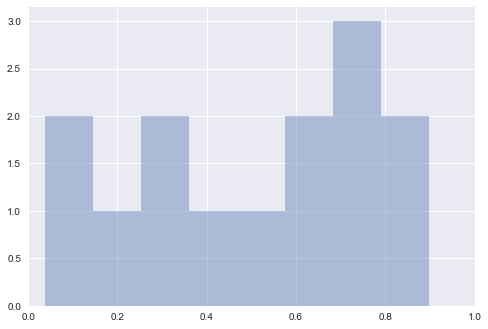

In [374]:
sns.distplot(p_vals, bins=8, kde=False)
plt.xlim((0,1))
plt.show()

As we can see, more than one of these ads seems to have p-values less than 0.05, despite our knowing that there actually no difference between the pages. This is why we do single A/B testing with multiple trials, as opposed to multiple hypothesis testing with only single trials. It is too easy for a p-value to give us a false positive if we just try a bunch of times.

## Many Tests for One Phenomenon
Sometimes, multiple testing can happen by accident. If many researchers are investigating the same phenomenon at the same time, then it's very possible that one of the researchers can end up with a lucky trial. That is exactly what happened during the 2010 World Cup.

### Paul the Octopus

Paul the Octopus was a common octopus who lived in a Sea Life Centre in Oberhausen, Germany. He is most well known for correctly guessing all seven soccer matches Germany played during the 2010 World Cup, as well as the final match, which was between Netherlands and Spain. 

Before a match was played, Paul's owners would place two boxes in his tank containing food, each box labeled with a different flag of the opposing countries. Whichever box Paul chose to eat from first was considered his prediction for the outcome of the match. 

<img src="https://news.bbcimg.co.uk/media/images/49659000/jpg/_49659323_octopus.jpg" width="400" />

So why was Paul so good at predicting the outcome of these matches? Was he actually psychic, or was he just lucky? We might ask what’s the chance he got all of the predictions correct, assuming he was just “guessing”?

Paul correctly predicted 8 of the 2010 World Cup games, each time he had a 1/2 chance of making the correct prediction. The one way to get all 8 matches correct out of 8 is:
$$(1/2)^8 = 1/256$$

So was he actually psychic? Or is there something more to uncover?

Turns out, there were tons of animals (some of them in the same zoo as Paul!) doing the same thing, trying to guess the outcome of their respective home countries' matches, including:
- Mani the Parakeet, from Singapore
- Leon the Porcupine, from Germany
- Petty the Pygmy Hippopotamus, from Germany
- Otto Armstrong the Octopus, from Germany
- Anton the Tamarin, from Germany
- Jimmy the Peruvian Guinea Pig, from Germany
- Xiaoge the Octopus, from China
- Pauline the Octopus, from the Netherlands
- Pino the Chimpanzee, from Estonia
- Apelsin the Red River Hog, from Estonia
- Harry the Crocodile, from Australia
None of whom got them all right (although Mani the Parakeet got 7 matches out of 8 right).

Some might argue that getting them all wrong would also be remarkable. So what are the chances that at least one of the 12 animals would get either all right or all wrong? 

We can use simple probability to figure this out. We have 12 trials (in this case, animals), where each independent trial has a $2*(1/2)^8 = 1/128$ chance of getting all predictions right or wrong. So what is the probability of having *at least* one success? That's $1 - P_{all \textrm{ }failures} = 1 - (127/128)^{12} = 1 - 0.910 = 0.090$

We have an 9% chance of getting an animal that will select all of the right predictions, and that's not including all of the animals in the world that were also doing these "predictions." That's not that rare - it's the dangers of multiple testing that caused this "phenomenon." This one octopus out of many different animals in the world happened to have guessed all of the right predictions, and the popularity of the situation caused it to become magical.

To those of you wondering if it really was luck, it has been shown that the species *Octopus vulgaris* is actually colorblind, and some believe that octopuses are drawn to horizontal shapes, hence Paul's decision to choose Germany, except when playing against Spain and Serbia.

In the end, we know that studies are more trustworthy when they are replicated. Data scientists should try to avoid cases like Paul the Octopus's where there has only been one real case of the animal correctly predicting a bunch of World Cup matches in a row. Only when we see him doing that for multiple soccer tournaments should we start looking at the data.

## P-Hacking is just the tip of the iceberg

As it turns out, p-hacking isn't the only thing data scientists and statisticians have to worry about when making sound inferences from data. There are many stages to the design and analysis of a successful study, as shown below (from Leek & Peng's *P values are just the tip of the iceberg*).

<img src='https://www.nature.com/polopoly_fs/7.25671.1429983882!/image/P1.jpg_gen/derivatives/landscape_300/P1.jpg'>

As shown, the last step of the whole "data pipeline" is the calculation of an inferential statistic like the p-value, and having a rule applied to it (e.g. p > 0.05). But there are many other decisions that are made beforehand, like experimental design or EDA, that can have much greater effects on the results - mistakes like simple rounding or measurement errors, choosing the wrong model, or not taking into account confounding factors can change everything. By changing the way data are cleaned, summarized, or modeled, we can achieve arbitrary levels of statistical significance.

A simple example of this would be in the case of rolling a pair of dice and getting two 6s. If we were to take a null hypothesis that the dice are fair and not weighted, and take our test statistic to be the sum of the dice, we will find that the p-value of this outcome will be 1/36 or 0.028, and gives us statistically signficant results that the dice are fair. But obviously, a single roll is not nearly enough rolls to provide us with good evidence to say whether the results are statistically significant or not, and shows that blindly applying the p-value without properly designing a good experiment can result in bad results.

In the end, what is most important is education on the subject of safe hypothesis testing, and making sure you don't fall into the follies of poor statistical decisions.